In [15]:
#  Imports

from src.parsers import HMParser
from src.repairs import PymooHMRepair
from src.scenes import PymooHMProblem

from src.metrics import CommunityMetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [ ]:
# Pymoo imports

from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination

algorithm = DE(pop_size=30,
               sampling=LHS(),
               variant="DE/rand/1/bin",
               CR=0.3,
               dither="vector",
               jitter=False,
               repair=PymooHMRepair(data=data))


# Default termination:
termination = DefaultSingleObjectiveTermination(xtol=1e-8,
                                                cvtol=1e-6,
                                                ftol=1e-6,
                                                period=1000,
                                                n_max_gen=2e3,
                                                n_max_evals=5e9)

customProblem = PymooHMProblem(data=data)

temp_res = minimize(customProblem,
                    algorithm,
                    termination=termination,
                    save_history=True,
                    verbose=True)

In [4]:
# Obj function value

temp_res.F

array([481.35687695])

In [5]:
# Solution

decoded_resources = customProblem.decode(temp_res.X)

In [6]:
# Show the decoded resources

decoded_resources

{'genActPower': [genActPower_00,
  genActPower_01,
  genActPower_02,
  genActPower_03,
  genActPower_04,
  genActPower_05,
  genActPower_06],
 'genExcActPower': [genExcActPower_00,
  genExcActPower_01,
  genExcActPower_02,
  genExcActPower_03,
  genExcActPower_04,
  genExcActPower_05,
  genExcActPower_06],
 'pImp': pImp,
 'pExp': pExp,
 'loadRedActPower': [loadRedActPower_00,
  loadRedActPower_01,
  loadRedActPower_02,
  loadRedActPower_03,
  loadRedActPower_04,
  loadRedActPower_05],
 'loadCutActPower': [loadCutActPower_00,
  loadCutActPower_01,
  loadCutActPower_02,
  loadCutActPower_03,
  loadCutActPower_04,
  loadCutActPower_05],
 'loadENS': [loadENS_00,
  loadENS_01,
  loadENS_02,
  loadENS_03,
  loadENS_04,
  loadENS_05],
 'loadActPower': [loadActPower_00,
  loadActPower_01,
  loadActPower_02,
  loadActPower_03,
  loadActPower_04,
  loadActPower_05],
 'storDchActPower': [storDchActPower_00,
  storDchActPower_01,
  storDchActPower_02],
 'storChActPower': [storChActPower_00, storCh

In [7]:
# Metrics

metric = CommunityMetrics()
print(metric)

Community Metrics available: 
- self_consumption
- total_produced
- total_consumed
- import_export_balance



In [8]:
# Check the metrics
metric.cmd_self_consumption(production=decoded_resources['genActPower'],
                            consumption=decoded_resources['loadActPower'])

3.933130219917035e-06

In [9]:
# Do a list of metrics at once

metric.check_metrics_2inputs(components_a=decoded_resources['genActPower'],
                             components_b=decoded_resources['loadActPower'],
                             metric_list=['self_consumption'])

{'self_consumption': 3.933130219917035e-06}

In [10]:
# Try to get an error
# Total consumption is not a valid metric with two components

metric.check_metrics_2inputs(components_a=decoded_resources['genActPower'],
                             components_b=decoded_resources['loadActPower'],
                             metric_list=['self_consumption',
                                          'total_consumed'])

The requested metric is not available with provided inputs:  total_consumed


{'self_consumption': 3.933130219917035e-06, 'total_consumed': None}

In [11]:
# Do note that the following metrics do not make sense to be called like this.
# Use at own discretion

metric.check_metrics_1input(decoded_resources['loadActPower'],
                            metric_list=['total_consumed'])

{'total_consumed': 342.4098855999999}

In [12]:
# Calculate the self sufficiency of the community

production_list = ['genActPower', 'loadCutActPower', 'loadRedActPower', 'loadENS',
                   'storDchActPower', 'v2gDchActPower']

consumption_list = ['genExcActPower', 'loadActPower', 'storChActPower',
                    'v2gChActPower']

# Append all the production values to a single array. Need to go a level deeper
community_productions = np.array([decoded_resources[prod][prod_elem]
                                  for prod in production_list
                                  for prod_elem in range(len(decoded_resources[prod]))])
community_productions = np.append(community_productions, decoded_resources['pImp'])

# Same for the consumption values
community_consumptions = np.array([decoded_resources[cons][cons_elem]
                                   for cons in consumption_list
                                   for cons_elem in range(len(decoded_resources[cons]))])
community_consumptions = np.append(community_consumptions, decoded_resources['pExp'])

print('Self consumption: ', metric.cmd_self_consumption(community_productions, community_consumptions))
print('Cost: ', metric.cmd_energy_costs(community_productions[:-1], community_consumptions[:-1]))

Self consumption:  1.0
Cost:  275.61543406040676


In [ ]:
# Pymoo imports

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination

algorithm_ga = GA(pop_size=100,
                  repair=PymooHMRepair(data=data))

# Note that the problem and termination are the same as before
temp_res_ga = minimize(customProblem,
                       algorithm_ga,
                       termination=termination,
                       save_history=False,
                       verbose=True)

In [14]:
# Do the same thing for the GA solutions

decoded_resources_ga = customProblem.decode(temp_res_ga.X)

community_productions_ga = np.array([decoded_resources_ga[prod][prod_elem]
                                     for prod in production_list
                                     for prod_elem in range(len(decoded_resources_ga[prod]))])
community_productions_ga = np.append(community_productions_ga, decoded_resources_ga['pImp'])

# Same for the consumption values
community_consumptions_ga = np.array([decoded_resources_ga[cons][cons_elem]
                                      for cons in consumption_list
                                      for cons_elem in range(len(decoded_resources_ga[cons]))])
community_consumptions_ga = np.append(community_consumptions_ga, decoded_resources['pExp'])

print('Self consumption: ', metric.cmd_self_consumption(community_productions_ga, community_consumptions_ga))
print('Cost: ', metric.cmd_energy_costs(community_productions_ga[:-1], community_consumptions_ga[:-1]))

Self consumption:  1.0033434401422323
Cost:  456.066607692105


In [31]:
# Plot the results of both algorithms side by side
# Build the DataFrames for an easy area visualization
# For this we'll consider the sum of each component over time

# DE
df_de_cons = pd.DataFrame({'loadActPower': np.sum(decoded_resources['loadActPower'][i].value
                                                  for i in range(len(decoded_resources['loadActPower']))),
                           'genExcActPower': np.sum(decoded_resources['genActPower'][i].value
                                                    for i in range(len(decoded_resources['genExcActPower']))),
                           'storChActPower': np.sum(decoded_resources['storChActPower'][i].value
                                                    for i in range(len(decoded_resources['storChActPower']))),
                           'v2gChActPower': np.sum(decoded_resources['v2gChActPower'][i].value
                                                   [i] for i in range(len(decoded_resources['v2gChActPower']))),
                           'pExp': decoded_resources['pExp']})
df_de_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_de_prod = pd.DataFrame({'genActPower': np.sum(decoded_resources['genActPower'][i].value
                                                 for i in range(len(decoded_resources['genActPower']))),
                           'loadCutActPower': np.sum(decoded_resources['loadCutActPower'][i].value
                                                     for i in range(len(decoded_resources['loadCutActPower']))),
                           'loadRedActPower': np.sum(decoded_resources['loadRedActPower'][i].value
                                                     for i in range(len(decoded_resources['loadRedActPower']))),
                           'loadENS': np.sum(decoded_resources['loadENS'][i].value
                                             for i in range(len(decoded_resources['loadENS']))),
                           'storDchActPower': np.sum(decoded_resources['storDchActPower'][i].value
                                                     for i in range(len(decoded_resources['storDchActPower']))),
                           'v2gDchActPower': np.sum(decoded_resources['v2gDchActPower'][i].value
                                                    for i in range(len(decoded_resources['v2gDchActPower']))),
                           'pImp': decoded_resources['pImp']})
df_de_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

# GA
df_ga_cons = pd.DataFrame({'loadActPower': np.sum(decoded_resources_ga['loadActPower'][i].value
                                                  for i in range(len(decoded_resources_ga['loadActPower']))),
                           'genExcActPower': np.sum(decoded_resources_ga['genActPower'][i].value
                                                    for i in range(len(decoded_resources_ga['genExcActPower']))),
                           'storChActPower': np.sum(decoded_resources_ga['storChActPower'][i].value
                                                    for i in range(len(decoded_resources_ga['storChActPower']))),
                           'v2gChActPower': np.sum(decoded_resources_ga['v2gChActPower'][i].value
                                                   [i] for i in range(len(decoded_resources_ga['v2gChActPower']))),
                           'pExp': decoded_resources_ga['pExp']})
df_ga_cons.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

df_ga_prod = pd.DataFrame({'genActPower': np.sum(decoded_resources_ga['genActPower'][i].value
                                                 for i in range(len(decoded_resources_ga['genActPower']))),
                           'loadCutActPower': np.sum(decoded_resources_ga['loadCutActPower'][i].value
                                                     for i in range(len(decoded_resources_ga['loadCutActPower']))),
                           'loadRedActPower': np.sum(decoded_resources_ga['loadRedActPower'][i].value
                                                     for i in range(len(decoded_resources_ga['loadRedActPower']))),
                           'loadENS': np.sum(decoded_resources_ga['loadENS'][i].value
                                             for i in range(len(decoded_resources_ga['loadENS']))),
                           'storDchActPower': np.sum(decoded_resources_ga['storDchActPower'][i].value
                                                     for i in range(len(decoded_resources_ga['storDchActPower']))),
                           'v2gDchActPower': np.sum(decoded_resources_ga['v2gDchActPower'][i].value
                                                    for i in range(len(decoded_resources_ga['v2gDchActPower']))),
                           'pImp': decoded_resources_ga['pImp']})
df_ga_prod.index = ['{:02d}:00'.format(i) for i in np.arange(24)]

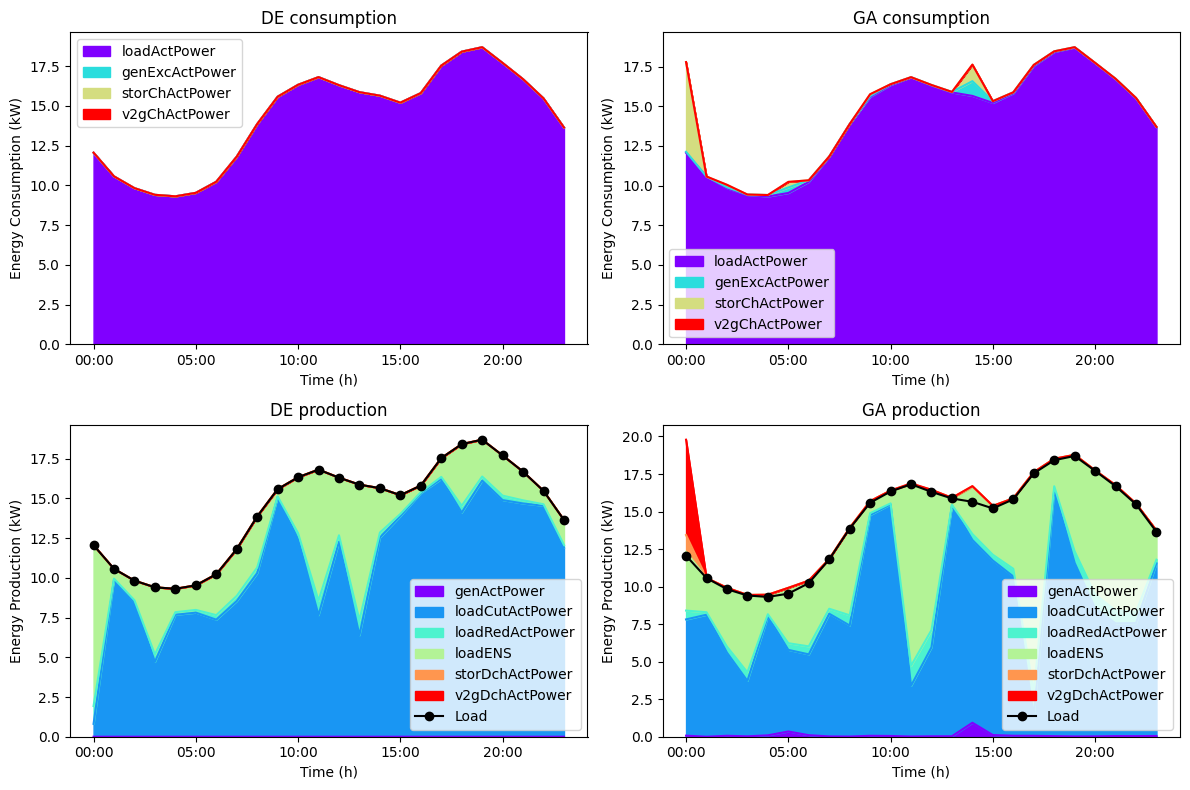

In [32]:
# Plot the results in an area graph

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot the DE
df_de_cons.plot.area(ax=axs[0, 0], cmap='rainbow')
axs[0, 0].set_title('DE consumption')
axs[0, 0].set_ylabel('Energy Consumption (kW)')
axs[0, 0].set_xlabel('Time (h)')

df_de_prod.plot.area(ax=axs[1, 0], cmap='rainbow')
axs[1, 0].plot(np.sum(data.load['p_forecast'], axis=0), 'o-', label='Load', color='black')
axs[1, 0].legend()
axs[1, 0].set_title('DE production')
axs[1, 0].set_ylabel('Energy Production (kW)')
axs[1, 0].set_xlabel('Time (h)')

# Plot the GA
df_ga_cons.plot.area(ax=axs[0, 1], cmap='rainbow')
axs[0, 1].set_title('GA consumption')
axs[0, 1].set_ylabel('Energy Consumption (kW)')
axs[0, 1].set_xlabel('Time (h)')

df_ga_prod.plot.area(ax=axs[1, 1], cmap='rainbow')
axs[1, 1].plot(np.sum(data.load['p_forecast'], axis=0), 'o-', label='Load', color='black')
axs[1, 1].legend()
axs[1, 1].set_title('GA production')
axs[1, 1].set_ylabel('Energy Production (kW)')
axs[1, 1].set_xlabel('Time (h)')

plt.tight_layout()

plt.show()